attention map

Using device: mps


Predicted class index: 2
Predicted probability: 0.999994158744812
Predicted class name: Beach


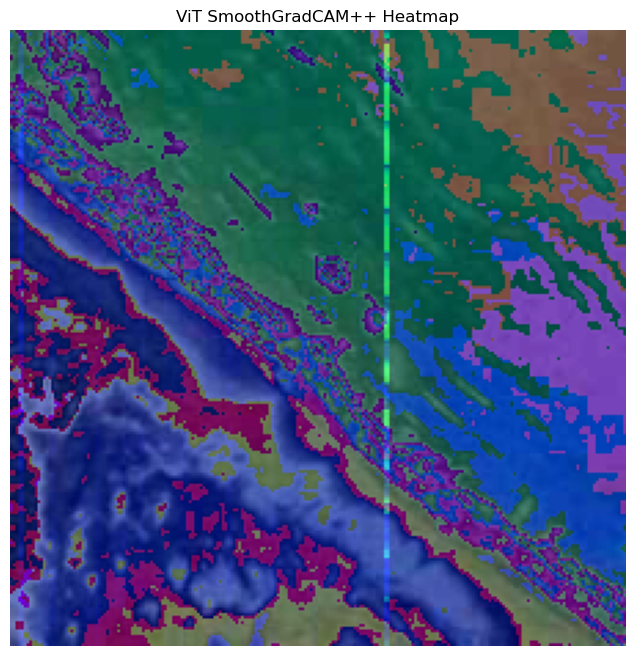

In [6]:
import torch
import timm
from torchvision import transforms, datasets
from PIL import Image
import matplotlib.pyplot as plt
from torchcam.methods import SmoothGradCAMpp
from torchvision.transforms.functional import to_pil_image
from torchcam.utils import overlay_mask
import torch.nn.functional as F  # 导入 F 用于 softmax

num_classes = 15  # 根据你微调时的类别数
model = timm.create_model('vit_base_patch16_224', pretrained=False, num_classes=num_classes)

# 选择设备（这里示例使用 MPS，如有 CUDA 可自行修改）
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print("Using device:", device)

# 加载微调好的权重（确保路径正确）
state_dict = torch.load('/Users/yaogunzhishen/Desktop/vit_model.pth', map_location=device)
model.load_state_dict(state_dict)
model = model.to(device)
model.eval()  # 设置为评估模式

# ---------------------------
# 2. 图像预处理
# ---------------------------
preprocess = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

# 加载并预处理单张图像
img_path = "/Users/yaogunzhishen/Desktop/datasets/test/Beach/009.jpg"  # 替换成你要预测的图像路径
img = Image.open(img_path).convert("RGB")
input_tensor = preprocess(img).unsqueeze(0).to(device)

from torchvision import datasets

# 假设你的训练数据集如下：
train_dataset = datasets.ImageFolder(root='/Users/yaogunzhishen/Desktop/datasets/test', transform=preprocess)
class_to_idx = train_dataset.class_to_idx
# 反转字典，得到索引到类别名称的映射
idx_to_class = {v: k for k, v in class_to_idx.items()}

# ---------------------------
# 3. 生成 CAM 热力图，并输出预测标签概率
# ---------------------------
# 为了生成梯度，暂时将模型切换到 train 模式，并确保参数可求梯度
model.train()
for param in model.parameters():
    param.requires_grad = True

with SmoothGradCAMpp(model) as cam_extractor:
    # 前向传播
    out = model(input_tensor)
    
    # 计算 softmax 概率
    probs = F.softmax(out, dim=1)
    
    # 获取预测类别索引
    pred_class = out.squeeze(0).argmax().item()
    print("Predicted class index:", pred_class)
    
    # 输出预测类别对应的概率
    pred_prob = probs[0, pred_class].item()
    print("Predicted probability:", pred_prob)
    
    predicted_class_name = idx_to_class.get(pred_class, "Unknown")
    print("Predicted class name:", predicted_class_name)
    
    # 生成 CAM 热力图
    activation_map = cam_extractor(pred_class, out)[0]

# 生成 CAM 后，将模型切换回 eval 模式（如果需要推理时更稳定）
model.eval()

# ---------------------------
# 4. 可视化热力图
# ---------------------------
# 将原始图像和 activation map 转换为 PIL Image 格式
img_pil = to_pil_image(input_tensor.squeeze(0).cpu())
# activation_map 通常为单通道张量，使用 mode='F' 保持浮点格式
act_map_pil = to_pil_image(activation_map.squeeze(0), mode='F')
# 将热力图叠加在原图上
result = overlay_mask(img_pil, act_map_pil, alpha=0.5)

# 显示结果
plt.figure(figsize=(8, 8))
plt.imshow(result)
plt.axis('off')
plt.title("ViT SmoothGradCAM++ Heatmap")
plt.show()

In [7]:
import torch
import timm
from torchvision import transforms, datasets
from PIL import Image
import matplotlib.pyplot as plt
from torchcam.methods import SmoothGradCAMpp
from torchvision.transforms.functional import to_pil_image
from torchcam.utils import overlay_mask
import torch.nn.functional as F  # 导入 F 用于 softmax

num_classes = 15  # 根据你微调时的类别数
model = timm.create_model('vit_base_patch16_224', pretrained=False, num_classes=num_classes)

# 选择设备（这里示例使用 MPS，如有 CUDA 可自行修改）
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print("Using device:", device)

# 加载微调好的权重（确保路径正确）
state_dict = torch.load('/Users/yaogunzhishen/Desktop/vit_model.pth', map_location=device)
model.load_state_dict(state_dict)
model = model.to(device)
model.eval()  # 设置为评估模式
print(model)

Using device: mps
VisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    (norm): Identity()
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (blocks): Sequential(
    (0): Block(
      (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=768, out_features=2304, bias=True)
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=768, out_features=768, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (drop_path): Identity()
      (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=768, out_features=3072, bias=True)
        (act): GELU(approximate='none')
        (fc2): Linear(in_features=3072, out_features=768, bias=True)
        (drop): Dropout(p=0.0, inplace=False)
      )
    )
    (1): Block(
      (norm1): LayerNorm((768,), eps=1e-06, 

位置编码消融实验

In [8]:
import torch
import timm
from torchvision import transforms, datasets
import torch.nn.functional as F
from torch.utils.data import DataLoader

# ---------------------------
# 配置部分
# ---------------------------
num_classes = 15                     # 根据你微调时的类别数
model_name = 'vit_base_patch16_224'    # ViT 模型名称
weights_path = '/Users/yaogunzhishen/Desktop/vit_model.pth'  # 微调好的权重路径
test_folder = '/Users/yaogunzhishen/Desktop/datasets/test'  # 测试集目录，每个类别一个子文件夹

# 选择设备（这里示例使用 MPS，如有 CUDA 可自行修改）
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print("Using device:", device)

# 图像预处理（需与训练时一致）
preprocess = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

# ---------------------------
# 模型加载函数
# ---------------------------
def load_model(with_pe=True):
    """
    加载 timm 的 ViT 模型，并根据参数决定是否使用位置编码（PE）。
    当 with_pe=False 时，将位置编码参数置零实现消融。
    """
    model = timm.create_model(model_name, pretrained=False, num_classes=num_classes)
    state_dict = torch.load(weights_path, map_location=device)
    model.load_state_dict(state_dict)
    model = model.to(device)
    if not with_pe and hasattr(model, 'pos_embed'):
        print("禁用位置编码")
        model.pos_embed.data.zero_()
    model.eval()
    return model

# ---------------------------
# 测试集评估函数
# ---------------------------
def evaluate_model(model, data_loader):
    """
    在测试集上评估模型的准确率
    """
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in data_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    accuracy = correct / total
    return accuracy

# ---------------------------
# 主程序
# ---------------------------
if __name__ == '__main__':
    # 加载测试集
    test_dataset = datasets.ImageFolder(root=test_folder, transform=preprocess)
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4)
    
    # 获取类别映射
    idx_to_class = {v: k for k, v in test_dataset.class_to_idx.items()}
    
    # 分别加载带位置编码和禁用位置编码的模型
    model_with_pe = load_model(with_pe=True)
    model_without_pe = load_model(with_pe=False)
    
    # 在测试集上评估两个模型的准确率
    acc_with_pe = evaluate_model(model_with_pe, test_loader)
    acc_without_pe = evaluate_model(model_without_pe, test_loader)
    
    print("使用位置编码模型的测试集准确率: {:.2%}".format(acc_with_pe))
    print("禁用位置编码模型的测试集准确率: {:.2%}".format(acc_without_pe))

Using device: mps
禁用位置编码
使用位置编码模型的测试集准确率: 96.11%
禁用位置编码模型的测试集准确率: 77.11%


transformer 层消融实验

In [9]:
import torch
import timm
import torch.nn as nn
from torchvision import transforms, datasets
from torch.utils.data import DataLoader
import torch.nn.functional as F

# ---------------------------
# 配置部分
# ---------------------------
num_classes = 15                     # 根据你微调时的类别数
model_name = 'vit_base_patch16_224'    # ViT 模型名称
weights_path = '/Users/yaogunzhishen/Desktop/vit_model.pth'  # 微调好的权重路径
test_folder = '/Users/yaogunzhishen/Desktop/datasets/test'  # 测试集目录，每个类别一个子文件夹

# 选择设备（示例使用 MPS，如有 CUDA 可自行修改）
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print("Using device:", device)

# 图像预处理（需与训练时保持一致）
preprocess = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

# ---------------------------
# 模型加载函数
# ---------------------------
def load_model_transformer_ablation(disable_transformer=False, disable_range=None):
    """
    加载 timm 的 ViT 模型，并根据参数对 transformer 层进行消融。
    参数：
      - disable_transformer: 是否进行 transformer 消融（True 表示执行消融）。
      - disable_range: 消融范围，元组形式 (start, end)，表示禁用 [start, end) 内的 transformer 层。
    """
    model = timm.create_model(model_name, pretrained=False, num_classes=num_classes)
    state_dict = torch.load(weights_path, map_location=device)
    model.load_state_dict(state_dict)
    model = model.to(device)
    
    if disable_transformer and hasattr(model, 'blocks'):
        print("消融 transformer 层：禁用层索引从 {} 到 {}（不包括后者）".format(disable_range[0], disable_range[1]))
        for i in range(disable_range[0], disable_range[1]):
            model.blocks[i] = nn.Identity()
    model.eval()
    return model

# ---------------------------
# 测试集评估函数
# ---------------------------
def evaluate_model(model, data_loader):
    """
    在测试集上评估模型的准确率
    """
    model.eval()
    total = 0
    correct = 0
    with torch.no_grad():
        for images, labels in data_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, dim=1)
            total += labels.size(0)
            correct += (preds == labels).sum().item()
    return correct / total

# ---------------------------
# 主程序
# ---------------------------
if __name__ == '__main__':
    # 加载测试集数据（要求测试集目录下按类别存放）
    test_dataset = datasets.ImageFolder(root=test_folder, transform=preprocess)
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4)
    
    # 1. 评估完整模型的准确率（基线）
    model_full = load_model_transformer_ablation(disable_transformer=False)
    acc_full = evaluate_model(model_full, test_loader)
    print("=== 完整模型 ===")
    print("完整模型准确率: {:.2%}".format(acc_full))
    
    # 查看完整模型中的 transformer 层数量（ViT 通常为 12 层）
    num_blocks = len(model_full.blocks)
    print("Transformer 层总数：", num_blocks)
    
    # 2. 分组消融：将 Transformer 分为三组，每组 4 层
    groups = [(0, 4), (4, 8), (8, 12)]
    
    for group_id, (start, end) in enumerate(groups, 1):
        print(f"\n=== 消融实验：组 {group_id}（Transformer blocks {start} 到 {end-1}） ===")
        # 加载模型，并在该组范围内消融 transformer 层
        model_ablate = load_model_transformer_ablation(disable_transformer=True, disable_range=(start, end))
        acc_ablate = evaluate_model(model_ablate, test_loader)
        print("禁用组 {} 后的模型准确率: {:.2%}".format(group_id, acc_ablate))

Using device: mps
=== 完整模型 ===
完整模型准确率: 96.11%
Transformer 层总数： 12

=== 消融实验：组 1（Transformer blocks 0 到 3） ===
消融 transformer 层：禁用层索引从 0 到 4（不包括后者）
禁用组 1 后的模型准确率: 14.94%

=== 消融实验：组 2（Transformer blocks 4 到 7） ===
消融 transformer 层：禁用层索引从 4 到 8（不包括后者）
禁用组 2 后的模型准确率: 56.00%

=== 消融实验：组 3（Transformer blocks 8 到 11） ===
消融 transformer 层：禁用层索引从 8 到 12（不包括后者）
禁用组 3 后的模型准确率: 85.11%


单个 Transformer Block 内分别禁用自注意力模块或 MLP 模块，从而进行消融实验

In [10]:
import torch
import timm
import torch.nn as nn
from torchvision import transforms, datasets
from torch.utils.data import DataLoader
import torch.nn.functional as F

# ---------------------------
# 配置部分
# ---------------------------
# ---------------------------
num_classes = 15                     # 根据你微调时的类别数
model_name = 'vit_base_patch16_224'    # ViT 模型名称
weights_path = '/Users/yaogunzhishen/Desktop/vit_model.pth'  # 微调好的权重路径
test_folder = '/Users/yaogunzhishen/Desktop/datasets/test'  # 测试集目录，每个类别一个子文件夹

# 选择设备（示例使用 MPS，如有 CUDA 可自行修改）
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print("Using device:", device)

# 图像预处理（与训练时保持一致）
preprocess = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

# ---------------------------
# 模型加载函数
# ---------------------------
def load_model():
    """
    加载 timm 的 ViT 模型，并加载微调好的权重。
    """
    model = timm.create_model(model_name, pretrained=False, num_classes=num_classes)
    state_dict = torch.load(weights_path, map_location=device)
    model.load_state_dict(state_dict)
    model = model.to(device)
    model.eval()
    return model

# ---------------------------
# 消融函数：禁用指定范围内的 Transformer Block 内的某个模块
# ---------------------------
def ablate_block_module_range(model, start_index, end_index, module_type='attn'):
    """
    在指定的 Transformer block 范围 [start_index, end_index) 内禁用某个模块，
    将每个 block 中对应的模块替换为 nn.Identity()。
    
    参数：
      model: 加载好的 ViT 模型
      start_index: 范围起始 block 索引（包含）
      end_index: 范围结束 block 索引（不包含）
      module_type: 要禁用的模块类型，支持 'attn'（自注意力模块）或 'mlp'（前馈网络）
    """
    if hasattr(model, 'blocks'):
        for i in range(start_index, end_index):
            if module_type == 'attn':
                print(f"禁用 Transformer block {i} 的自注意力模块")
                model.blocks[i].attn = nn.Identity()
            elif module_type == 'mlp':
                print(f"禁用 Transformer block {i} 的 MLP 模块")
                model.blocks[i].mlp = nn.Identity()
            else:
                print("module_type 参数无效，请选择 'attn' 或 'mlp'")
    else:
        print("模型没有 'blocks' 属性，无法进行消融")
    return model

# ---------------------------
# 测试集评估函数
# ---------------------------
def evaluate_model(model, data_loader):
    """
    在测试集上评估模型准确率
    """
    model.eval()
    total = 0
    correct = 0
    with torch.no_grad():
        for images, labels in data_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, dim=1)
            total += labels.size(0)
            correct += (preds == labels).sum().item()
    return correct / total

# ---------------------------
# 主程序
# ---------------------------
if __name__ == '__main__':
    # 加载测试集
    test_dataset = datasets.ImageFolder(root=test_folder, transform=preprocess)
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4)
    
    # 1. 评估完整模型的准确率（基线）
    model_full = load_model()
    acc_full = evaluate_model(model_full, test_loader)
    print("=== 完整模型 ===")
    print("完整模型准确率: {:.2%}".format(acc_full))
    
    # 查看完整模型中 Transformer 层数量（ViT 通常为 12 层）
    num_blocks = len(model_full.blocks)
    print("Transformer 层总数：", num_blocks)
    
    # 2. 将 Transformer 分为三组：0-3, 4-7, 8-11，每组包含 4 层
    groups = [(0, 4), (4, 8), (8, 12)]
    
    for group_id, (start, end) in enumerate(groups, 1):
        print(f"\n=== 消融实验：组 {group_id}（Transformer blocks {start} 到 {end-1}） ===")
        # (a) 禁用该组内所有 block 的自注意力模块
        model_ablate_attn = load_model()  # 重新加载完整模型
        model_ablate_attn = ablate_block_module_range(model_ablate_attn, start, end, module_type='attn')
        acc_attn = evaluate_model(model_ablate_attn, test_loader)
        print("禁用组 {} 自注意力模块后的准确率: {:.2%}".format(group_id, acc_attn))
        
        # (b) 禁用该组内所有 block 的 MLP 模块
        model_ablate_mlp = load_model()  # 重新加载完整模型
        model_ablate_mlp = ablate_block_module_range(model_ablate_mlp, start, end, module_type='mlp')
        acc_mlp = evaluate_model(model_ablate_mlp, test_loader)
        print("禁用组 {} MLP 模块后的准确率: {:.2%}".format(group_id, acc_mlp))

Using device: mps
=== 完整模型 ===
完整模型准确率: 96.11%
Transformer 层总数： 12

=== 消融实验：组 1（Transformer blocks 0 到 3） ===
禁用 Transformer block 0 的自注意力模块
禁用 Transformer block 1 的自注意力模块
禁用 Transformer block 2 的自注意力模块
禁用 Transformer block 3 的自注意力模块
禁用组 1 自注意力模块后的准确率: 12.89%
禁用 Transformer block 0 的 MLP 模块
禁用 Transformer block 1 的 MLP 模块
禁用 Transformer block 2 的 MLP 模块
禁用 Transformer block 3 的 MLP 模块
禁用组 1 MLP 模块后的准确率: 14.00%

=== 消融实验：组 2（Transformer blocks 4 到 7） ===
禁用 Transformer block 4 的自注意力模块
禁用 Transformer block 5 的自注意力模块
禁用 Transformer block 6 的自注意力模块
禁用 Transformer block 7 的自注意力模块
禁用组 2 自注意力模块后的准确率: 50.33%
禁用 Transformer block 4 的 MLP 模块
禁用 Transformer block 5 的 MLP 模块
禁用 Transformer block 6 的 MLP 模块
禁用 Transformer block 7 的 MLP 模块
禁用组 2 MLP 模块后的准确率: 69.72%

=== 消融实验：组 3（Transformer blocks 8 到 11） ===
禁用 Transformer block 8 的自注意力模块
禁用 Transformer block 9 的自注意力模块
禁用 Transformer block 10 的自注意力模块
禁用 Transformer block 11 的自注意力模块
禁用组 3 自注意力模块后的准确率: 84.11%
禁用 Transformer block 8 的 MLP 模块
禁用 Trans

归一化层消融实验


In [51]:
import torch
import timm
import torch.nn as nn
from torchvision import transforms, datasets
from torch.utils.data import DataLoader
import torch.nn.functional as F

# ---------------------------
# 配置部分
# ---------------------------
num_classes = 15                     # 根据你微调时的类别数
model_name = 'vit_base_patch16_224'    # ViT 模型名称
weights_path = '/Users/yaogunzhishen/Desktop/my_vit_best.pth'  # 微调好的权重路径
test_folder = '/Users/yaogunzhishen/Desktop/9517dataset/test'  # 测试集目录（目录下需按类别分文件夹）

# 选择设备（示例使用 MPS，如有 CUDA 可自行修改）
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print("Using device:", device)

# 图像预处理（需与训练时保持一致）
preprocess = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

# ---------------------------
# 模型加载函数
# ---------------------------
def load_model():
    """
    加载 timm 的 ViT 模型，并加载微调好的权重。
    """
    model = timm.create_model(model_name, pretrained=False, num_classes=num_classes)
    state_dict = torch.load(weights_path, map_location=device)
    model.load_state_dict(state_dict)
    model = model.to(device)
    model.eval()
    return model

# ---------------------------
# 消融函数：禁用指定范围内 Transformer block 内的归一化层
# ---------------------------
def ablate_layernorm_range(model, start_index, end_index):
    """
    在指定的 Transformer block 范围 [start_index, end_index) 内，将所有的 LayerNorm 层替换为 nn.Identity()。
    
    参数：
      model: 加载好的 ViT 模型
      start_index: 范围起始 block 索引（包含）
      end_index: 范围结束 block 索引（不包含）
    """
    if hasattr(model, 'blocks'):
        for i in range(start_index, end_index):
            block = model.blocks[i]
            # 常见的 ViT block 中通常有 norm1 和 norm2 两个归一化层
            if hasattr(block, 'norm1'):
                print(f"禁用 Transformer block {i} 的 norm1")
                block.norm1 = nn.Identity()
            if hasattr(block, 'norm2'):
                print(f"禁用 Transformer block {i} 的 norm2")
                block.norm2 = nn.Identity()
    else:
        print("模型没有 'blocks' 属性，无法进行消融")
    return model

# ---------------------------
# 测试集评估函数
# ---------------------------
def evaluate_model(model, data_loader):
    """
    在测试集上评估模型的准确率
    """
    model.eval()
    total = 0
    correct = 0
    with torch.no_grad():
        for images, labels in data_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, dim=1)
            total += labels.size(0)
            correct += (preds == labels).sum().item()
    return correct / total

# ---------------------------
# 主程序
# ---------------------------
if __name__ == '__main__':
    # 加载测试集数据（要求测试集目录下按类别分文件夹）
    test_dataset = datasets.ImageFolder(root=test_folder, transform=preprocess)
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4)
    
    # 1. 评估完整模型的准确率（基线）
    model_full = load_model()
    acc_full = evaluate_model(model_full, test_loader)
    print("=== 完整模型 ===")
    print("完整模型准确率: {:.2%}".format(acc_full))
    
    # 查看完整模型中 Transformer 层数量（ViT 通常为 12 层）
    num_blocks = len(model_full.blocks)
    print("Transformer 层总数：", num_blocks)
    
    # 2. 分组消融：将 Transformer 分为三组，每组 4 层
    groups = [(0, 4), (4, 8), (8, 12)]
    
    for group_id, (start, end) in enumerate(groups, 1):
        print(f"\n=== 消融实验：组 {group_id}（Transformer blocks {start} 到 {end-1} 的归一化层） ===")
        model_ablate = load_model()  # 重新加载完整模型
        model_ablate = ablate_layernorm_range(model_ablate, start, end)
        acc_ablate = evaluate_model(model_ablate, test_loader)
        print("禁用组 {} 内归一化层后的模型准确率: {:.2%}".format(group_id, acc_ablate))

Using device: mps
=== 完整模型 ===
完整模型准确率: 96.38%
Transformer 层总数： 12

=== 消融实验：组 1（Transformer blocks 0 到 3 的归一化层） ===
禁用 Transformer block 0 的 norm1
禁用 Transformer block 0 的 norm2
禁用 Transformer block 1 的 norm1
禁用 Transformer block 1 的 norm2
禁用 Transformer block 2 的 norm1
禁用 Transformer block 2 的 norm2
禁用 Transformer block 3 的 norm1
禁用 Transformer block 3 的 norm2
禁用组 1 内归一化层后的模型准确率: 6.67%

=== 消融实验：组 2（Transformer blocks 4 到 7 的归一化层） ===
禁用 Transformer block 4 的 norm1
禁用 Transformer block 4 的 norm2
禁用 Transformer block 5 的 norm1
禁用 Transformer block 5 的 norm2
禁用 Transformer block 6 的 norm1
禁用 Transformer block 6 的 norm2
禁用 Transformer block 7 的 norm1
禁用 Transformer block 7 的 norm2
禁用组 2 内归一化层后的模型准确率: 33.46%

=== 消融实验：组 3（Transformer blocks 8 到 11 的归一化层） ===
禁用 Transformer block 8 的 norm1
禁用 Transformer block 8 的 norm2
禁用 Transformer block 9 的 norm1
禁用 Transformer block 9 的 norm2
禁用 Transformer block 10 的 norm1
禁用 Transformer block 10 的 norm2
禁用 Transformer block 11 的 norm1
禁用 Transforme

残差消融

In [11]:
import torch
import timm
import torch.nn as nn
from torchvision import transforms, datasets
from torch.utils.data import DataLoader
import torch.nn.functional as F

# ---------------------------
# 配置部分
# ---------------------------
# ---------------------------
num_classes = 15                     # 根据你微调时的类别数
model_name = 'vit_base_patch16_224'    # ViT 模型名称
weights_path = '/Users/yaogunzhishen/Desktop/vit_model.pth'  # 微调好的权重路径
test_folder = '/Users/yaogunzhishen/Desktop/datasets/test'  # 测试集目录，每个类别一个子文件夹

# 选择设备（示例使用 MPS，如有 CUDA 可自行修改）
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print("Using device:", device)

# 图像预处理（需与训练时保持一致）
preprocess = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

# ---------------------------
# 模型加载函数
# ---------------------------
def load_model():
    """
    加载 timm 的 ViT 模型，并加载微调好的权重。
    """
    model = timm.create_model(model_name, pretrained=False, num_classes=num_classes)
    state_dict = torch.load(weights_path, map_location=device)
    model.load_state_dict(state_dict)
    model = model.to(device)
    model.eval()
    return model

# ---------------------------
# 残差连接消融：包装 Transformer Block
# ---------------------------
class ResidualAblatedBlock(nn.Module):
    def __init__(self, original_block):
        """
        用于包装原始 Transformer block，消除残差连接（即不将输入 x 与子模块输出相加）
        """
        super().__init__()
        # 保留原始 block 内的各个子模块
        self.norm1 = original_block.norm1
        self.attn = original_block.attn
        self.drop_path = original_block.drop_path  # 如果 drop_path_rate 为 0 则为 Identity
        self.norm2 = original_block.norm2
        self.mlp = original_block.mlp

    def forward(self, x):
        # 原始 block 通常为：
        #   x = x + drop_path(attn(norm1(x)))
        #   x = x + drop_path(mlp(norm2(x)))
        # 此处我们去除残差连接，直接使用子模块输出
        x1 = self.attn(self.norm1(x))
        x1 = self.drop_path(x1)
        # 取消第一处残差相加
        x = x1
        x2 = self.mlp(self.norm2(x))
        x2 = self.drop_path(x2)
        # 取消第二处残差相加
        x = x2
        return x

def ablate_residual_range(model, start_index, end_index):
    """
    在指定的 Transformer block 范围 [start_index, end_index) 内，将原始 block 替换为 ResidualAblatedBlock（即禁用残差连接）
    
    参数：
      model: 加载好的 ViT 模型
      start_index: 范围起始 block 索引（包含）
      end_index: 范围结束 block 索引（不包含）
    """
    if hasattr(model, 'blocks'):
        for i in range(start_index, end_index):
            print(f"消融 Transformer block {i} 的残差连接")
            model.blocks[i] = ResidualAblatedBlock(model.blocks[i])
    else:
        print("模型没有 'blocks' 属性，无法进行残差连接消融")
    return model

# ---------------------------
# 测试集评估函数
# ---------------------------
def evaluate_model(model, data_loader):
    """
    在测试集上评估模型的准确率
    """
    model.eval()
    total = 0
    correct = 0
    with torch.no_grad():
        for images, labels in data_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, dim=1)
            total += labels.size(0)
            correct += (preds == labels).sum().item()
    return correct / total

# ---------------------------
# 主程序
# ---------------------------
if __name__ == '__main__':
    # 加载测试集数据（要求测试集目录下按类别分文件夹）
    test_dataset = datasets.ImageFolder(root=test_folder, transform=preprocess)
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4)
    
    # 1. 评估完整模型的准确率（基线）
    model_full = load_model()
    acc_full = evaluate_model(model_full, test_loader)
    print("=== 完整模型 ===")
    print("完整模型准确率: {:.2%}".format(acc_full))
    
    # 查看完整模型中 Transformer 层数量（ViT 通常为 12 层）
    num_blocks = len(model_full.blocks)
    print("Transformer 层总数：", num_blocks)
    
    # 2. 分组消融：将 Transformer 分为三组，每组 4 层（例如组1：blocks 0-3，组2：blocks 4-7，组3：blocks 8-11）
    groups = [(0, 4), (4, 8), (8, 12)]
    
    for group_id, (start, end) in enumerate(groups, 1):
        print(f"\n=== 消融实验：组 {group_id}（Transformer blocks {start} 到 {end-1} 的残差连接） ===")
        model_ablate = load_model()  # 重新加载完整模型
        model_ablate = ablate_residual_range(model_ablate, start, end)
        acc_ablate = evaluate_model(model_ablate, test_loader)
        print("禁用组 {} 内残差连接后的模型准确率: {:.2%}".format(group_id, acc_ablate))

Using device: mps
=== 完整模型 ===
完整模型准确率: 96.11%
Transformer 层总数： 12

=== 消融实验：组 1（Transformer blocks 0 到 3 的残差连接） ===
消融 Transformer block 0 的残差连接
消融 Transformer block 1 的残差连接
消融 Transformer block 2 的残差连接
消融 Transformer block 3 的残差连接
禁用组 1 内残差连接后的模型准确率: 10.17%

=== 消融实验：组 2（Transformer blocks 4 到 7 的残差连接） ===
消融 Transformer block 4 的残差连接
消融 Transformer block 5 的残差连接
消融 Transformer block 6 的残差连接
消融 Transformer block 7 的残差连接
禁用组 2 内残差连接后的模型准确率: 7.78%

=== 消融实验：组 3（Transformer blocks 8 到 11 的残差连接） ===
消融 Transformer block 8 的残差连接
消融 Transformer block 9 的残差连接
消融 Transformer block 10 的残差连接
消融 Transformer block 11 的残差连接
禁用组 3 内残差连接后的模型准确率: 6.67%
